# 18.S097/16.S092 Problem Set 2 Solutions

## Problem 1 (5+5+5 points)

**(a)** Implement the power method for the $5 \times 5$ matrix $A=A^T$ with entries given below (in Julia format, but you can easily paste the rows into Python if you want), starting with a random $x$.  (Don't forget to normalize $x$ on each step.)  Plot the first component `x[1]` of the vector (`x[0]` in Python) as a function of the iteration $k$, for 50 iterations.    You should find that it is *not* converging, even if you do thousands of iterations.  Explain why, by analyzing $A$.

**(b)** For the same power iteration, also plot the estimated eigenvalue from the Rayleigh quotient $R(x) = x^T A x / x^T x$.   Show experimentally that this ratio *is* converging with iteration, but that it converges to a *different* value depending on the starting $x$.   Explain this theoretically.  (Hint: imagine expanding your initial vector in terms of the eigenvectors of $A$, and write $R(x)$ as we did in class.  What happens as the iterations increase?  Your analysis of $A$ from part (a) is relevant here.)

**(c)** Take the **last two iterations** $x_{49}, x_{50}$ of your power iteration from part (a).   Given these two vectors, construct an orthonormal basis for their span and implement the Rayleigh–Ritz procedure from class.  Show that the Ritz values accurately give you the biggest two $|\lambda|$ of $A$ and that the Ritz vectors are corresponding eigenvectors.

In [1]:
A = [1.4476317999449781 -0.6465393230357954   0.2033943818754874    -0.6010878430154134  0.23307116396384292
    -0.6465393230357954  0.245131330148544   -0.010910634569569148  -0.22452148400766606 1.102670053450075
     0.2033943818754874 -0.010910634569569148 0.5527569734349188     1.2392098548325268 -0.00039661249386200957
    -0.6010878430154134 -0.22452148400766606  1.2392098548325268    -0.2892571481659739  0.8941545793109221
     0.23307116396384292 1.102670053450075   -0.00039661249386200957 0.8941545793109221  0.043737044637532294]

5×5 Matrix{Float64}:
  1.44763   -0.646539    0.203394     -0.601088   0.233071
 -0.646539   0.245131   -0.0109106    -0.224521   1.10267
  0.203394  -0.0109106   0.552757      1.23921   -0.000396612
 -0.601088  -0.224521    1.23921      -0.289257   0.894155
  0.233071   1.10267    -0.000396612   0.894155   0.043737

### Solutions:

**(a)** First, let's implement the power method and track the convergence history of $x_1$ as suggested:

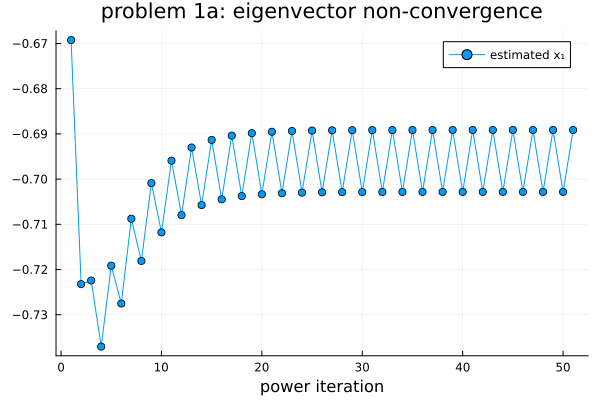

In [2]:
using LinearAlgebra

x = randn(5)
x1 = [x[1]] # array to track x[1] convergence history
for k = 1:50
    x = normalize!(A*x) # power-iteration step
    push!(x1, x[1])
end

using Plots
plot(x1, marker=:circle, label="estimated x₁", title="problem 1a: eigenvector non-convergence", xlabel="power iteration")
# scatter!(est_λ, label="estimated λ")

As we can see, the $x_1$ component seems to oscillates forever, apparently without converging.    (The exact magnitude of the oscillation will depend upon the random starting $x$.)

The reason for this is easy to understand if we look at the **eigenvalues of A**:

In [3]:
eigvals(A)

5-element Vector{Float64}:
 -1.999999999999999
 -0.500000000000001
  0.9999999999999997
  1.4999999999999996
  2.0000000000000004

Up to roundoff errors, the eigenvalues of this matrix are $\lambda = -2, +2, 1.5, 1, -0.5$, so the power iteration will be dominated by *two* largest-magnitude eigenvalues $\lambda = \pm 2$.   That is, if we expand the initial vector $x$ in the orthonormal basis of eigenvectors $q_i$, $x = \sum_i q_i (q_i^T x)$, after the $n$-th iteration of the power method we have:
$$
A^n x = \sum_i \lambda_i^n q_i (q_i^T x) \approx (+2)^n q_1 (q_1^T x) + (-2)^n q_2 (q_2^T x)
$$
which never converges, even after we normalize to $A^n x / \Vert A^n x \Vert$ since the two terms add on *even* iterations $n$ and subtract on *odd* iterations $n$.

**(b)** Let's plot the power iterations of the Rayleigh quotient from several different starting points.

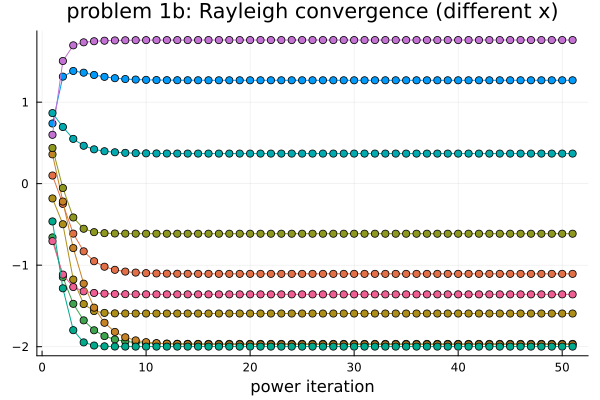

In [4]:
est_λs = []

for i = 1:10
    x = randn(5)
    est_λ = [x'*A*x / x'x]
    x1 = [x[1]]
    for k = 1:50
        x = normalize!(A*x)
        push!(est_λ, x'*A*x / x'x)
    end
    push!(est_λs, est_λ)
end

using Plots, LaTeXStrings
plot(est_λs[1], marker=:circle)
for i = 2:length(est_λs)
    plot!(est_λs[i], marker=:circle)
end
plot!(legend=false, title="problem 1b: Rayleigh convergence (different x)", xlabel="power iteration")

Clearly, the Rayleigh quotient converges to some value between $-2$ and $+2$, but what value it converges *to* depends on the initial $x$.

It is easy to see why if we simply plug $y = A^n x \approx (+2)^n q_1 c_1 + (-2)^n q_2 c_2$ (where $c_i = q_i^T x$) into the Rayleigh quotient, the orthogonality of the eigenvectors causes the cross terms to vanish (similar to the analysis of the min–max theorem in class), and we get:
$$
R(A^n x) \approx \frac{(+2) [(+2)^n c_1]^2 + (-2) [(-2)^n c_2]^2}{[(+2)^n c_1]^2 + [(-2)^n c_2]^2}
$$
But since the $(\pm 2)^n$ factors are squared, their signs disappear, and the resulting $2^n$ terms cancel on the top and bottom, leaving:$$
R(A^n x) \approx \frac{(+2) c_1^2 + (-2) c_2^2}{c_1^2 + c_2^2}
$$
which is clearly a value (between $-2$ and $+2$ depending only on $c_1 = q_1^T x$ and $c_2 = q_2^T x$, i.e. on the initial vector $x$ of the power iteration.  This corresponds to what we see above.

As usual with power iterations, the convergence is exponentially fast, determined by how quickly the $(\pm 2)^n$ terms grow compared to the other values, albeit squared as discussed in class (and as seen from the squaring of the coefficients in the analysis above).  In this case, the next-biggest |λ| is 1.5, so we expect convergence with errors that decay $\sim (1.5/2)^{2n}$.

**(c)** From the analysis above, we see that the iterations are eventually dominated by *two* of the eigenvectors, but the linear combination oscillates from step to step.  Hence, if we take *two* iterations $A^{n-1} x$ and $A^n x$, they are linearly independent vectors that span the eigenvectors $q_1, q_2$.  Therefore, if we look **only in the subspace spanned by two iterations**, we should find two nearly exact eigenvectors.

The Rayleigh–Ritz procedure provides a general method to find approximate eigenvectors within *any* subspace: construct an orthormal basis $Q$ of the subspace, find the projected matrix $H = Q^T A Q$, compute the eigensolutions $H z = \nu z$, and then the Ritz vectors $x = Qz$ are approximate eigenvectors of $A$ with eigenvalue $\approx \nu$.

So, we just need to take the last two iterants $x_{49}, x_{50} \in \mathbb{R}^5$, construct an $5 \times 2$ orthonormal basis $Q$, and then follow the Rayleigh-Ritz procedure.  We could construct $Q$ by e.g. Gram–Schmidt, but it is a lot easier to just call [`qr(X)`](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.qr) to form the ["thin" QR factorization](https://en.wikipedia.org/wiki/QR_decomposition) — as noted last quarter, this generally the right way to orthonormalize a given basis.

In [5]:
x = randn(5)
for k = 1:49
    x = normalize!(A*x)
end
x49 = x
x50 = normalize!(A*x)

Q = Matrix(qr([x49 x50]).Q) # get the Q̂ factor from the thin QR factorization
H = Q' * A * Q # the Rayleigh–Ritz projection of A onto the subspace
F = eigen(H)
@show ν = F.values # the Ritz values ν
;

ν = F.values = [-1.9999999999999911, 1.9999999999999145]


As desired, the Ritz values after 50 iterations are indeed $\approx \pm 2$, the correct eigenvalues.

Now, we can just form the Ritz vectors $Qz$, our approximate eigenvectors, and check that $A(Qz) - \nu (Qz) \approx 0$:

In [6]:
X = Q * F.vectors # QZ, the 5×2 matrix of the two Ritz vectors

@show norm(A * X[:,1] - ν[1] * X[:,1])
@show norm(A * X[:,2] - ν[2] * X[:,2])
;

norm(A * X[:, 1] - ν[1] * X[:, 1]) = 1.8293271550554655e-7
norm(A * X[:, 2] - ν[2] * X[:, 2]) = 2.066730861125332e-7


As desired, these are quite small — not at the level of roundoff errors, but limited by the accuracy of 50 iterations of the power method.  (It would approach roundoff level if we ran more iterations.)

We could also check both Ritz vectors at once by using a matrix norm:

In [7]:
norm(A * X - X * Diagonal(ν)) / norm(A * X)

9.758210833100826e-8

## Problem 2 (5+5 points)

Consider the Rayleigh quotient $R(x) = \frac{x^T A x}{x^T x}$ for a real matrix $A$.

**(a)** Suppose $A = A^T$.  In class, we claimed that *any* eigenvector of $A$ will then be an extremum of $R$.  Show this: explicitly compute $\nabla R$ (exercise your 18.02 skills!) and show that $\nabla R = 0$ if and only if $x$ is an eigenvector.

**(b)** Suppose that $A \ne A^T$.   In this case, eigenvectors of $A$ will *not* generally be extrema of $R$.  Instead, the extrema of $R$ (where $\nabla R = 0$) will be eigenvectors of *some other* matrix.  What matrix?  (Revisit your calculation from (a): what changes if $A$ is not symmetric?)

## Solutions:

**(a)** The key algebraic step here is to derive the fact that, for $A = A^T$, we have:
$$
\nabla (x^T A x) = 2 Ax
$$
This can be derived in a number of ways.  An 18.02-style derivation would look component by component, realizing that $x^T A x = \sum_{i,j} x_i A_{i,j} x_j$.  Then, taking the partial derivative with respect to $x_k$ (the $k$-th component of the gradient) gives two terms:
$$
\frac{\partial}{\partial x_k} \left( \sum_{i,j} x_i A_{i,j} x_j \right) = \sum_{j} A_{k, j} x_j + \sum_{i} x_i A_{i,k} \, .
$$
But $\sum_{j} A_{k, j} x_j$ is the $k$-th component of $A x$, and $\sum_{i} x_i A_{i,k}$ is the $k$-th component of $A^T x$. Since $A = A^T$, we can combine these two terms into $2Ax$, yielding the result above.   (A more elegant and "holistic" way of deriving these kinds of results, without going component-by-component, is taught in [18.063: Matrix Calculus](https://github.com/mitmath/matrixcalc).)

It immediately follows that 
$$
\nabla (x^T x) = 2 x
$$
from the special case of $A = I$.

Given these results, taking the gradient of the Rayleigh quotient is then simply applying the quotient rule:
$$
\nabla R = \frac{1}{x^T x} \left[ \nabla(x^T A x) - R(x) \nabla{x^T x}  \right] = \boxed{\frac{2}{x^T x} \left[ Ax - R(x) x  \right]} \, .
$$
That means that $R(x) = 0$ if and only if $x \ne 0$ (so that $R$ is defined) and
$$
Ax = \underbrace{R(x)}_{\text{scalar}} x
$$
which is exactly the equation of an eigenvector.

**(b)** There are several ways to go about this, but the easiest way is to realize that $x^T A x$ is a scalar, and thus equal to its own transpose:
$$
x^T A x = (x^T A x)^T = x^T A^T x
$$
And therefore
$$
x^T A x = \frac{1}{2} \left( x^T A x + (x^T A x)^T \right) = x^T \frac{A + A^T}{2} x \, .
$$
Plugging this into the Rayleigh quotient, we get:
$$
R(x) = \frac{x^T A x}{x^T x} = \frac{x^T \frac{A + A^T}{2} x}{x^T x}
$$
But this is exactly a Rayleigh quotient for the real-symmetric matrix $\boxed{B = \frac{A + A^T}{2}}$ (called the "operator real part" or "symmetric part" of $A$).  So, by part (a), the Rayleigh quotient extrema occur at eigenvectors of $B$, which equals $A$ if and only if $A$ is symmetric.

## Problem 3 (5+5+5 points)

This problem is based problem 8.3.5 from the [*FNC* book section 8.3](https://fncbook.com/inviter).  This exercise concerns the $n^2\times n^2$ sparse matrix defined by `A = FNC.poisson(n)` for integer $n$ — see the provided [Julia implementation](https://github.com/fncbook/FNCFunctions.jl/blob/236e736cd052081d67c487c8835dcabb0221437a/src/chapter08.jl#L153-L166) or the [Python implementation `poisson2d(n)`](https://github.com/fncbook/fnc/blob/0149be86ebf930b6455c3b8500f8dc818afadda7/python/pkg/FNC/FNC08.py#L135-L141). It represents a discretized ($n \times n$ grid) model of a vibrating square membrane held fixed around the edges.

**(a)** Implement inverse iteration (the power method with $A^{-1}$) with zero shift).  Do *not* explicitly compute $A^{-1}$.  Instead, compute a sparse LU factorization *once* (or better yet sparse Cholesky, since this matrix is symmetric positive-definite) using an appropriate library function, and re-use it for each power iteration.  Using sufficiently many iterations your code, **find the eigenvalue** $\lambda$ closest to zero for $n=10,15,20,25$ to many digits of accuracy.

The eigenvalues can be interpreted as the squares of the vibration frequencies.  It turns out that the lowest vibration frequency is $\sqrt{2}$ for an exact wave equation in the $n \to \infty$ limit, so the lowest eigenvalue should be converging to $2$ as $n$ increases.  `poisson` uses a second-order center-difference approximation, so the error should be $O(1/n^2)$ — **verify that your λ data** is consistent with this prediction.

**(b)** For each $n$ in part (a), apply 50 steps of inverse iteration. On one graph, **plot the convergence of fractional error** $|\Delta \lambda| / |\lambda|$ in the estimated eigenvalue  **as a function of iteration** for each of the four $n$'s.  (Use the value from (a) as the "exact" value … if you ran (a) for much more than 50 iterations it should be accurate enough.)  Why should this converge at similar rates for different $n$ values?

**(c)** Let `v` be the eigenvector found by your inverse iteration for $n=25$. **Make a plot of the vibration mode** by reshaping `v` into an $n\times n$ matrix (use something like a heatmap, contour, or 3d surface plot).   For $n \to \infty$, it turns out that this eigenvector should converge to the function $\sin(x) \sin(y)$ on a $[0,\pi] \times [0, \pi]$ domain — **plot this analytical solution side-by-side** with your computed eigenvector.

## Solutions:

**(a)** We'll copy-paste the linked `poisson` function, which returns our sparse matrix.   Then, we'll implement an `inviter` function that performs inverse iteration, computing a Cholesky factorization (a more-efficient form of LU factorization for symmetric-definite matrices) *once* and re-using it on each step.  This should converge to the eigenvalue closest to zero.

Our `inviter` function also returns the convergence history of the Rayleigh-quotient λ estimate so that we can visualize the fact that it is converging in part (b).

In [8]:
using SparseArrays, LinearAlgebra

function poisson(n)
    D =
        spdiagm(
            -1 => fill(-1, n-1),
            0 => fill(2, n),
            1 => fill(-1, n-1)) * (n+1)^2 / π^2
    return Hermitian(kron(D, I(n)) + kron(I(n), D))
end

poisson (generic function with 1 method)

In [9]:
function inviter(A, N, x₀=randn(float(eltype(A)), size(A,1)))
    λ_history = eltype(x₀)[]
    F = cholesky(A)
    x = x₀
    for k = 1:N
        x = normalize!(F \ x)
        push!(λ_history, x'*A*x / (x'x))
    end
    return λ_history[end], x, λ_history
end

inviter (generic function with 2 methods)

Now we'll perform 500 inverse iterations (far more than enough, as we'll see in part b) for each of the requested $n$ values, and get the following result:

In [10]:
ns = [10,15,20,25]
λ = [inviter(poisson(n), 500)[1] for n in ns]

4-element Vector{Float64}:
 1.9864424118578978
 1.9935827280899212
 1.9962727722601115
 1.9975678494961708

These four eigenvalues are clearly approaching $2.0$ by the "eyeball metric", and we can also plot their difference from $2$ on a log–log scale versus $n$ to show that they conform to the predicted $O(1/n^2)$ convergence:

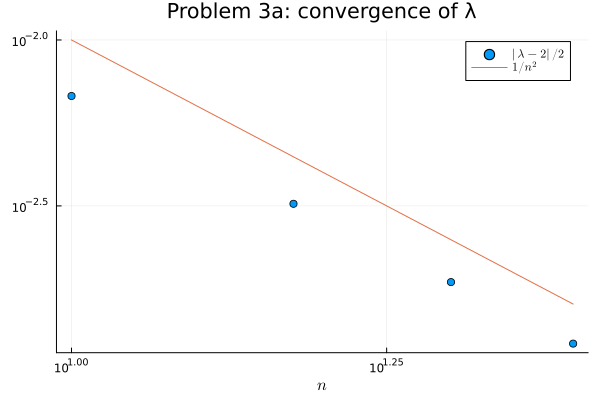

In [11]:
relerr(val, exact) = abs(val - exact) / abs(exact)

using Plots, LaTeXStrings
scatter(ns, relerr.(λ,2), xaxis=:log10, yaxis=:log10, label=L"|\lambda - 2| / 2", xlabel=L"n")
plot!(ns, 1 ./ ns.^2, label=L"1/n^2", title="Problem 3a: convergence of λ")

The dots clearly seem to be following approximately parallel to the predicted rate.

**(b)** Our function from above already returns the convergence history, so we just need to plot it:

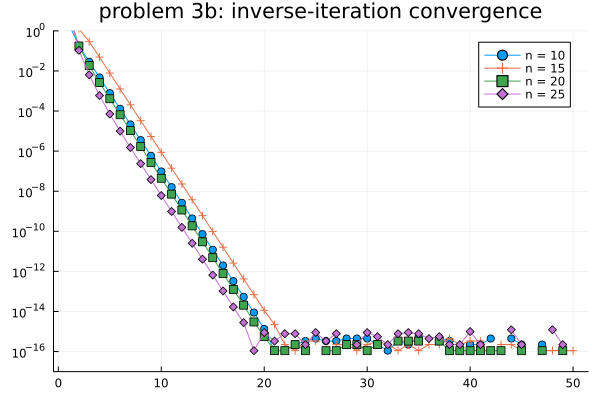

In [12]:
λhist = [inviter(poisson(n), 50)[3] for n in ns]

plot(title="problem 3b: inverse-iteration convergence", yaxis=:log10, ylim=(1e-17, 1), yticks=exp10.(-16:2:0))
markers = [:circle, :cross, :square, :diamond]
for i = 1:length(ns)
    λerr = relerr.(λhist[i], λ[i])
    plot!(λerr, marker=markers[mod1(i, 4)], label="n = $(ns[i])")
end
plot!()

They are all converging at roughly the same rate.  This shouldn't be surprising, since convergence is determined by the ratio of the two smallest |λ|, and these are *both* converging with $n$ as $O(1/n^2)$ similar to what we saw in part (a).

**(c)** Now, let's do the requested plot of the eigenvector for $n=50$, vs. the exact solution $\sim \sin(x) \sin(y)$ for $n \to \infty$.

Note that the eigenvector will have a *random sign* depending on the initial (random) guess, which makes it harder to compare to the sine solution, so we'll do a quick post-processing step to choose the sign.

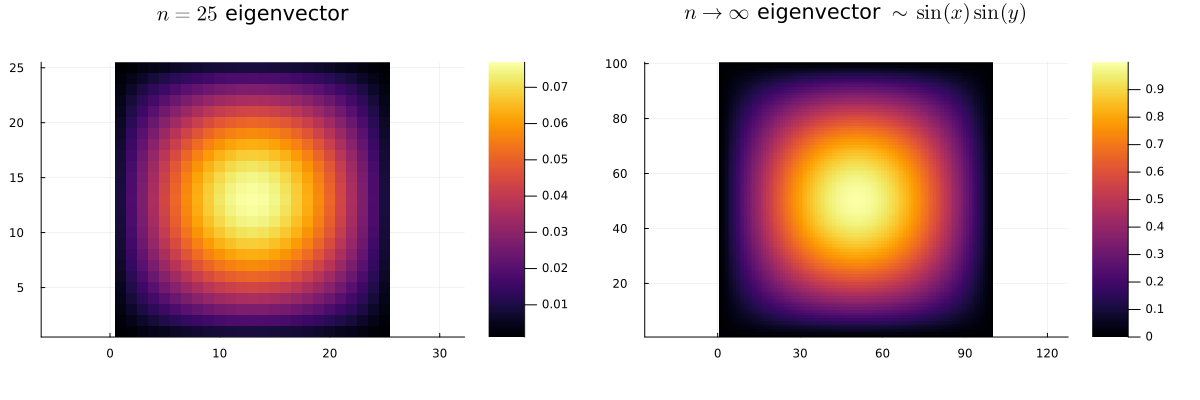

In [13]:
n = 25
v = reshape(inviter(poisson(n), 50)[2], n, n)
v *= sign(sum(v)) # make it positive
p_n25 = heatmap(v, aspect_ratio=:equal, title="\$n=25\$ eigenvector")

x = range(0, pi, length=100)
p_exact = heatmap(sin.(x) .* sin.(x'), aspect_ratio=:equal, title=L"$n \to \infty$ eigenvector $\sim \sin(x) \sin(y)$")

plot(p_n25, p_exact, size=(1200,400))

As predicted, the eigenvector is indeed quite similar to $\sin(x) \sin(y)$!